In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gc

In [13]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [14]:
#url = 'https://raw.githubusercontent.com/raidake/SC1015-Data-Science-Real-or-Fake-Job-Ads/main/reallyCleanData.csv?token=GHSAT0AAAAAABTT3LBZJC7RJ7R4TTIRPZQWYS2VQLA'
#tD = pd.read_csv(url)

tD = pd.read_csv("reallyCleanData.csv")

In [15]:
#tD['text'] = tD['company_profile'] + ' ' + tD['description'] + ' ' + tD['requirements'] 

In [16]:
del tD['telecommuting']
del tD['has_company_logo']
del tD['has_questions']
del tD['minSalary']
del tD['maxSalary']
del tD['haveSalary']
del tD['title']
del tD['department']
#del tD['company_profile']
#del tD['description']
#del tD['requirements']
#del tD['benefits']
del tD['employment_type']
del tD['required_experience']
del tD['required_education']
del tD['industry']
del tD['function']
del tD['job_id']
del tD['country']
del tD['state']
del tD['city']

In [17]:
tD.head()

,company_profile,description,requirements,benefits,fraudulent
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0
3,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


CLEANING TEXT FOR SPACY AND TFIDF

In [18]:
cD = tD.replace(np.nan, '', regex=True)
def standardize_text(df, text_field):
    df2 = df.copy(deep=True)
    df2[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df2[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df2[text_field] = df[text_field].str.lower()
    return df2

cat_var = ["company_profile","description","benefits","requirements"]


df_clean = standardize_text(cD, "company_profile")
df_clean = standardize_text(df_clean, "description")
df_clean = standardize_text(df_clean, "benefits")
df_clean = standardize_text(df_clean, "requirements")

In [19]:
df_clean

,company_profile,description,requirements,benefits,fraudulent
0,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,unspecified,0
1,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,0
2,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,unspecified,0
3,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,0
4,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,0
...,...,...,...,...,...
17875,vend is looking for some awesome new talent to...,just in case this is the first time you’ve vis...,to ace this role you:will eat comprehensive st...,what can you expect from us?we have an open cu...,0
17876,weblinc is the e-commerce platform and service...,the payroll accountant will focus primarily on...,- b.a. or b.s. in accounting- desire to have f...,health &amp; wellnessmedical planprescription ...,0
17877,we provide full time permanent positions for m...,experienced project cost control staff enginee...,at least 12 years professional experience.abil...,unspecified,0
17878,unspecified,nemsia studios is looking for an experienced v...,1. must be fluent in the latest versions of co...,competitive salary (compensation will be based...,0


In [20]:
#del df_clean['tokens']
#del df_clean['lemm_tokens']

tD = df_clean.copy()

In [21]:
tD

,company_profile,description,requirements,benefits,fraudulent
0,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,unspecified,0
1,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,0
2,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,unspecified,0
3,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,0
4,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,0
...,...,...,...,...,...
17875,vend is looking for some awesome new talent to...,just in case this is the first time you’ve vis...,to ace this role you:will eat comprehensive st...,what can you expect from us?we have an open cu...,0
17876,weblinc is the e-commerce platform and service...,the payroll accountant will focus primarily on...,- b.a. or b.s. in accounting- desire to have f...,health &amp; wellnessmedical planprescription ...,0
17877,we provide full time permanent positions for m...,experienced project cost control staff enginee...,at least 12 years professional experience.abil...,unspecified,0
17878,unspecified,nemsia studios is looking for an experienced v...,1. must be fluent in the latest versions of co...,competitive salary (compensation will be based...,0


# REMOVE STOP WORDS LIKE 'and' , 'a', etc...

In [22]:
import nltk
nltk.download('stopwords')


stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# LEMMATIZE & TOKENIZE

In [23]:
lemmatizer = WordNetLemmatizer()

In [ ]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

tD['text'] = tD['company_profile'] + ' ' + tD['description'] + ' ' + tD['requirements']  + ' ' + tD['benefits']
cat_var = ["company_profile","description","benefits","requirements", 'text']
#cat_var = ['text']
for var in cat_var:
    tokenizer = RegexpTokenizer(r'\w+')
    tD[var] = tD[var].apply(tokenizer.tokenize)
    lemmatizer = WordNetLemmatizer()
    obj = tD[var]
    listOfDFRows = obj.to_numpy().tolist()
    lemm_tokens = []
    lemms = []
    for i in tqdm(range(len(listOfDFRows))):
        for words in listOfDFRows[i]:
            if words not in stopwords.words('english'):
                lemmas = lemmatizer.lemmatize(words.lower(), pos='v')
                lemms.append(lemmas)
        lemm_tokens.append(lemms)
        lemms = []
    a = lemm_tokens
    %store a
    tD[var] = a

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████| 17880/17880 [05:05<00:00, 58.50it/s]


Stored 'a' (list)


100%|████████████████████████████████████████████████████████████████████████████| 17880/17880 [09:26<00:00, 31.57it/s]


Stored 'a' (list)


100%|███████████████████████████████████████████████████████████████████████████| 17880/17880 [01:35<00:00, 186.96it/s]


Stored 'a' (list)


100%|████████████████████████████████████████████████████████████████████████████| 17880/17880 [04:03<00:00, 73.34it/s]


Stored 'a' (list)


 95%|████████████████████████████████████████████████████████████████████████▏   | 16992/17880 [19:17<01:00, 14.64it/s]

In [25]:

#tD['text'] = tD['company_profile'] + tD['description'] + tD['requirements'] + tD['benefits']
tD['tokens'] = tD['text']
tD.to_csv('tokenized.csv', index = False)

In [31]:
tD

,company_profile,description,requirements,benefits,fraudulent,text,tokens
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",experience with content management systems a m...,Unspecified,0,"[we, food52, create, groundbreaking, award, wi...","[we, food52, create, groundbreaking, award, wi..."
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,what we expect from you:your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, worlds, cloud, video, production,...","[90, second, worlds, cloud, video, production,..."
2,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",implement pre-commissioning and commissioning ...,Unspecified,0,"[valor, service, provide, workforce, solutions...","[valor, service, provide, workforce, solutions..."
3,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"education: bachelor’s or master’s in gis, busi...",Our culture is anything but corporate—we have ...,0,"[our, passion, improve, quality, life, geograp...","[our, passion, improve, quality, life, geograp..."
4,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,qualifications:rn license in the state of texa...,Full Benefits Offered,0,"[spotsource, solutions, llc, global, human, ca...","[spotsource, solutions, llc, global, human, ca..."
...,...,...,...,...,...,...,...
17875,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,to ace this role you:will eat comprehensive st...,What can you expect from us?We have an open cu...,0,"[vend, look, awesome, new, talent, come, join,...","[vend, look, awesome, new, talent, come, join,..."
17876,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- b.a. or b.s. in accounting- desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,"[weblinc, e, commerce, platform, service, prov...","[weblinc, e, commerce, platform, service, prov..."
17877,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,at least 12 years professional experience.abil...,Unspecified,0,"[we, provide, full, time, permanent, position,...","[we, provide, full, time, permanent, position,..."
17878,Unspecified,Nemsia Studios is looking for an experienced v...,1. must be fluent in the latest versions of co...,Competitive salary (compensation will be based...,0,"[unspecified, nemsia, studios, look, experienc...","[unspecified, nemsia, studios, look, experienc..."


In [13]:
spacytD = df_clean.copy()
spacytD


,company_profile,description,requirements,benefits,fraudulent
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",experience with content management systems a m...,Unspecified,0
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,what we expect from you:your key responsibilit...,What you will get from usThrough being part of...,0
2,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",implement pre-commissioning and commissioning ...,Unspecified,0
3,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"education: bachelor’s or master’s in gis, busi...",Our culture is anything but corporate—we have ...,0
4,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,qualifications:rn license in the state of texa...,Full Benefits Offered,0
...,...,...,...,...,...
17875,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,to ace this role you:will eat comprehensive st...,What can you expect from us?We have an open cu...,0
17876,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- b.a. or b.s. in accounting- desire to have f...,Health &amp; WellnessMedical planPrescription ...,0
17877,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,at least 12 years professional experience.abil...,Unspecified,0
17878,Unspecified,Nemsia Studios is looking for an experienced v...,1. must be fluent in the latest versions of co...,Competitive salary (compensation will be based...,0


In [15]:
import spacy
spacylemmatizer = spacy.load("en_core_web_sm", disable = ['parser','ner'])
df_clean['text'] = df_clean['company_profile'] + ' ' + df_clean['description'] + ' ' + df_clean['requirements'] + ' ' + df_clean['benefits'] 
spacytD['token'] = [spacylemmatizer(text) for text in df_clean.text]

In [22]:
spacytD

,company_profile,description,requirements,benefits,fraudulent,token
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",experience with content management systems a m...,Unspecified,0,"(We, 're, Food52, ,, and, we, 've, created, a,..."
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,what we expect from you:your key responsibilit...,What you will get from usThrough being part of...,0,"(90, Seconds, ,, the, worlds, Cloud, Video, Pr..."
2,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",implement pre-commissioning and commissioning ...,Unspecified,0,"(Valor, Services, provides, Workforce, Solutio..."
3,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"education: bachelor’s or master’s in gis, busi...",Our culture is anything but corporate—we have ...,0,"(Our, passion, for, improving, quality, of, li..."
4,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,qualifications:rn license in the state of texa...,Full Benefits Offered,0,"(SpotSource, Solutions, LLC, is, a, Global, Hu..."
...,...,...,...,...,...,...
17875,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,to ace this role you:will eat comprehensive st...,What can you expect from us?We have an open cu...,0,"(Vend, is, looking, for, some, awesome, new, t..."
17876,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- b.a. or b.s. in accounting- desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,"(WebLinc, is, the, e, -, commerce, platform, a..."
17877,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,at least 12 years professional experience.abil...,Unspecified,0,"(We, Provide, Full, Time, Permanent, Positions..."
17878,Unspecified,Nemsia Studios is looking for an experienced v...,1. must be fluent in the latest versions of co...,Competitive salary (compensation will be based...,0,"(Unspecified, Nemsia, Studios, is, looking, fo..."


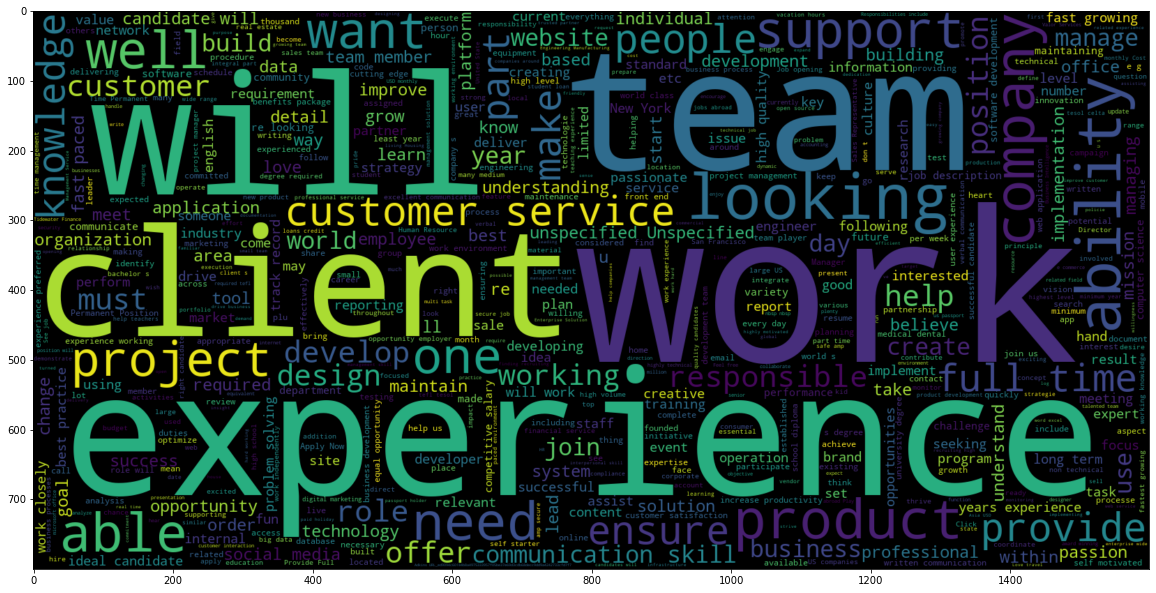

In [75]:

tD['text'] = df_clean['company_profile'] + ' ' + df_clean['description'] + ' ' + df_clean['requirements'] + ' '+ df_clean['benefits']
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(tD[tD.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

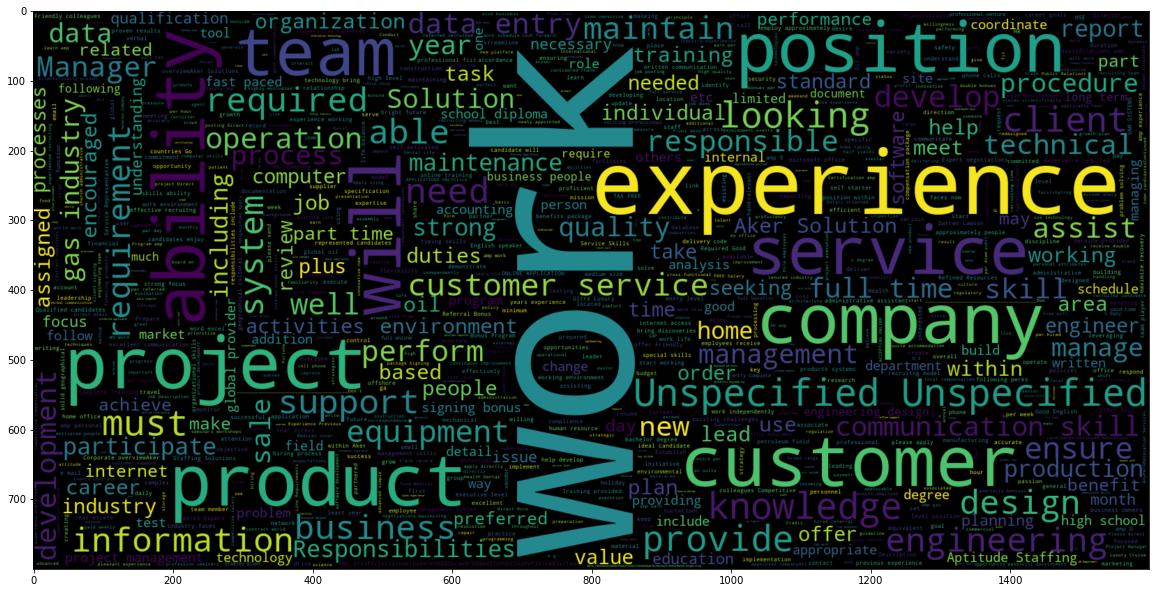

In [76]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(tD[tD.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

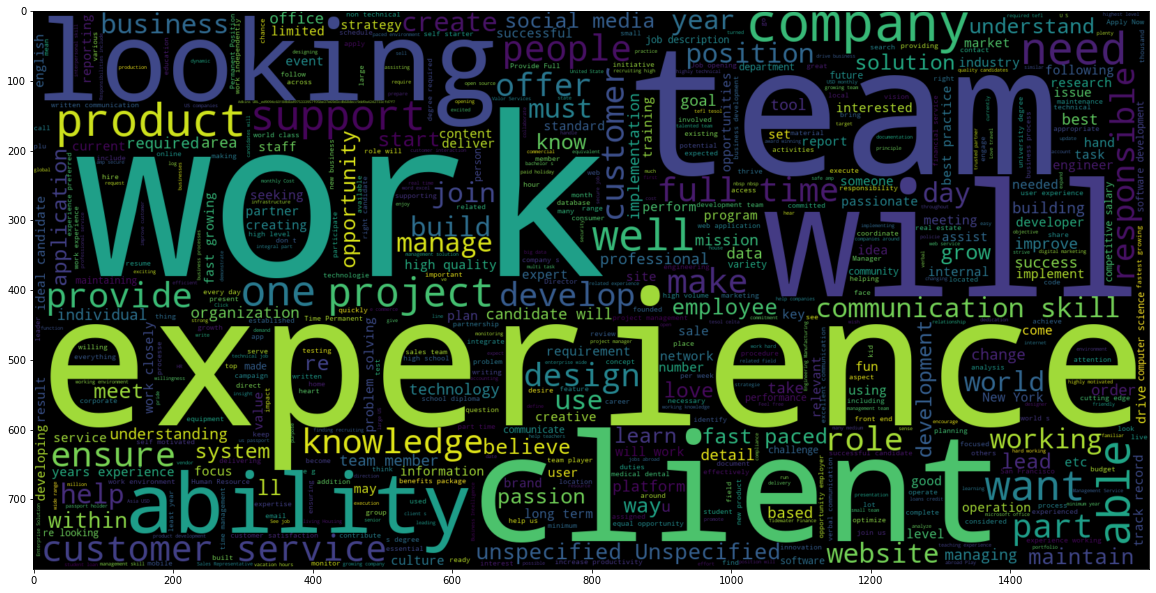

In [23]:
spacytD['text'] = spacytD['company_profile'] + ' ' + spacytD['description'] + ' ' + spacytD['requirements'] + ' ' + spacytD['benefits'] 
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(spacytD[spacytD.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

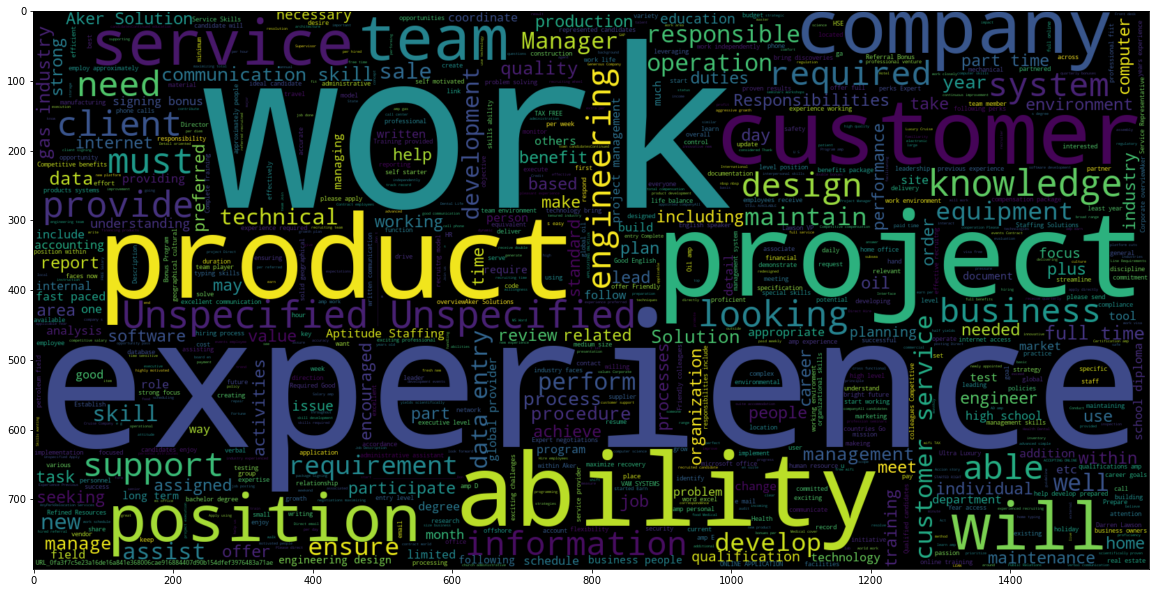

In [24]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(spacytD[spacytD.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [57]:
tD = pd.read_csv('tokenized.csv' )
tD

,company_profile,description,requirements,benefits,fraudulent,text
0,"['food52', 'create', 'groundbreaking', 'award'...","['food52', 'fast', 'grow', 'jam', 'beard', 'aw...","['experience', 'content', 'management', 'syste...",['unspecified'],0,"['food52', 'create', 'groundbreaking', 'award'..."
1,"['90', 'second', 'worlds', 'cloud', 'video', '...","['organise', 'focus', 'vibrant', 'awesome', 'p...","['expect', 'key', 'responsibility', 'communica...","['get', 'usthrough', 'part', '90', 'second', '...",0,"['90', 'second', 'worlds', 'cloud', 'video', '..."
2,"['valor', 'service', 'provide', 'workforce', '...","['client', 'locate', 'houston', 'actively', 's...","['implement', 'pre', 'commission', 'commission...",['unspecified'],0,"['valor', 'service', 'provide', 'workforce', '..."
3,"['passion', 'improve', 'quality', 'life', 'geo...","['company', 'esri', 'environmental', 'systems'...","['education', 'bachelor', 'master', 'gi', 'bus...","['culture', 'anything', 'corporate', 'collabor...",0,"['passion', 'improve', 'quality', 'life', 'geo..."
4,"['spotsource', 'solutions', 'llc', 'global', '...","['job', 'title', 'itemization', 'review', 'man...","['qualifications', 'rn', 'license', 'state', '...","['full', 'benefit', 'offer']",0,"['spotsource', 'solutions', 'llc', 'global', '..."
...,...,...,...,...,...,...
17875,"['vend', 'look', 'awesome', 'new', 'talent', '...","['case', 'first', 'time', 'visit', 'website', ...","['ace', 'role', 'eat', 'comprehensive', 'state...","['expect', 'us', 'open', 'culture', 'openly', ...",0,"['vend', 'look', 'awesome', 'new', 'talent', '..."
17876,"['weblinc', 'e', 'commerce', 'platform', 'serv...","['payroll', 'accountant', 'focus', 'primarily'...","['b', 'b', 'account', 'desire', 'fun', 'love',...","['health', 'amp', 'wellnessmedical', 'planpres...",0,"['weblinc', 'e', 'commerce', 'platform', 'serv..."
17877,"['provide', 'full', 'time', 'permanent', 'posi...","['experience', 'project', 'cost', 'control', '...","['least', '12', 'years', 'professional', 'expe...",['unspecified'],0,"['provide', 'full', 'time', 'permanent', 'posi..."
17878,['unspecified'],"['nemsia', 'studios', 'look', 'experience', 'v...","['1', 'must', 'fluent', 'latest', 'versions', ...","['competitive', 'salary', 'compensation', 'bas...",0,"['unspecified', 'nemsia', 'studios', 'look', '..."


In [32]:
#tD["text"] = tD["company_profile"] + " " + tD["description"] + " " + tD["requirements"]
wordtokens = tD["tokens"]

def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  
tfidf.fit(wordtokens)
wordtfidf = tfidf.transform(wordtokens)

# Use elbow method

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


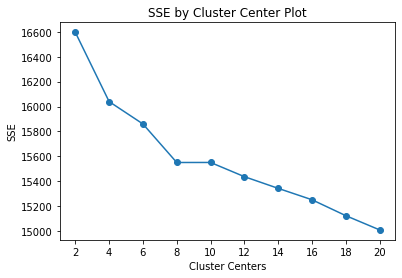

In [33]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(wordtfidf, 20)

In [47]:
gc.collect()

1160

In [44]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(wordtfidf)

In [45]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(wordtfidf, clusters)

C:\Users\User\anaconda3\envs\gpu2\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


MemoryError: Unable to allocate 2.21 GiB for an array with shape (3000, 98794) and data type float64

In [46]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(wordtfidf, clusters, tfidf.get_feature_names(), 10)

C:\Users\User\anaconda3\envs\gpu2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


MemoryError: Unable to allocate 13.2 GiB for an array with shape (17880, 98794) and data type float64

# Using KMeans (Approx. 200)

In [ ]:
from sklearn.cluster import KMeans
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(wordtfidf)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [25]:
kmeans = KMeans(n_clusters=200)
kmeans.fit(wordtfidf)
result = pd.concat([tD,pd.DataFrame(wordtfidf.toarray(),columns=tfidf.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(wordtfidf)

In [58]:
result[['fraudulent','text','cluster']]


,fraudulent,text,cluster
0,0,"we're food52, and we've created a groundbreaki...",47
1,0,"90 seconds, the worlds cloud video production ...",87
2,0,valor services provides workforce solutions th...,0
3,0,our passion for improving quality of life thro...,189
4,0,spotsource solutions llc is a global human cap...,77
...,...,...,...
17875,0,vend is looking for some awesome new talent to...,56
17876,0,weblinc is the e-commerce platform and service...,11
17877,0,we provide full time permanent positions for m...,177
17878,0,unspecified nemsia studios is looking for an e...,3


In [33]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df


result = df_column_uniquify(result)



In [59]:
result1 = result[['fraudulent','text','cluster']]
result1

,fraudulent,text,cluster
0,0,"we're food52, and we've created a groundbreaki...",47
1,0,"90 seconds, the worlds cloud video production ...",87
2,0,valor services provides workforce solutions th...,0
3,0,our passion for improving quality of life thro...,189
4,0,spotsource solutions llc is a global human cap...,77
...,...,...,...
17875,0,vend is looking for some awesome new talent to...,56
17876,0,weblinc is the e-commerce platform and service...,11
17877,0,we provide full time permanent positions for m...,177
17878,0,unspecified nemsia studios is looking for an e...,3
